In [113]:
import pandas as pd
import numpy
from sklearn.preprocessing import MinMaxScaler
from pandas import concat
from pandas import DataFrame
numpy.random.seed(44)
import tensorflow
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import joblib

#Suhu RH

In [244]:
df = pd.read_csv('/content/dataset_suhu_&_kelembapan.csv', delimiter=';')

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8036 entries, 0 to 8035
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Tavg    7859 non-null   float64
 1   RH_avg  7855 non-null   float64
dtypes: float64(2)
memory usage: 125.7 KB


In [246]:
split = int(len(df)*.6)
dfTrain = df.iloc[:split, :]
dfTest = df.iloc[split:, :]

scaler = MinMaxScaler(feature_range=(0, 1))
dfTrain = scaler.fit_transform(dfTrain)
dfTest = scaler.transform(dfTest)

In [248]:
joblib.dump(scaler, 'scalersuhurh.gz')

['scalersuhurh.gz']

In [126]:
def deret_waktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [127]:
lag = 2
output = 1
reframedTrain = deret_waktu(dfTrain, lag, output)
reframedTest = deret_waktu(dfTest, lag, output)

In [128]:
reframedTest.head()

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
2,0.353659,0.686275,0.451220,0.627451,0.451220,0.549020
3,0.451220,0.627451,0.451220,0.549020,0.451220,0.549020
4,0.451220,0.549020,0.451220,0.549020,0.402439,0.470588
5,0.451220,0.549020,0.402439,0.470588,0.402439,0.549020
6,0.402439,0.470588,0.402439,0.549020,0.475610,0.568627


In [129]:
YTrain = reframedTrain.iloc[:, -2:].values
YTest = reframedTest.iloc[:, -2:].values
n_features = len(df.columns)
n_obs = lag * n_features
train_X, train_y = reframedTrain.iloc[:, :n_obs].values, YTrain
test_X, test_y = reframedTest.iloc[:, :n_obs].values, YTest
train_X = train_X.reshape((train_X.shape[0], lag, n_features))
test_X = test_X.reshape((test_X.shape[0], lag, n_features))

In [132]:
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[-2:])))
model.add(Dense(2, activation="relu"))
model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
              loss='mse')  
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 256)               265216    
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 265,730
Trainable params: 265,730
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500

Epoch 1: val_loss improved from inf to 0.00792, saving model to model_checkpoint.h5
761/761 - 18s - loss: 0.0159 - val_loss: 0.0079 - 18s/epoch - 24ms/step
Epoch 2/500

Epoch 2: val_loss improved from 0.00792 to 0.00763, saving model to model_checkpoint.h5
761/761 - 3s - loss: 0.0099 - val_loss: 0.0076 - 3s/epoch - 4ms/step
Epoch 3/500

Epoch 3: val_loss improved from 0.00763 to 0.00749, saving model to model_checkpoint.h5
761/761 - 3s - loss: 0.0097 - val_loss: 0.0075 - 3s/epoch - 4ms/step
Epoch 4/500

Epoch 4: val_loss improved from 0.00749 to 0.00745, saving model to model_checkpoint.h5
761/761 - 3s - loss: 0.0096 - val_loss: 0.0074 - 3s/epoch - 4ms/step
Epoch 5/500

Epoch 5: val_loss improved from 0.00745 to 0.00738, saving model to model_checkpoint.h5
761/761 - 3s - loss: 0.0096 - val_loss: 0.0074 - 3s/epoch - 4ms/step
Epoch 6/500

Epoch 6: val_loss improved from 0.00738 to 0.00730, saving model to model_checkpoint.h5
761/761 - 3s - loss: 0.0095 - val_loss: 0.0073 - 3

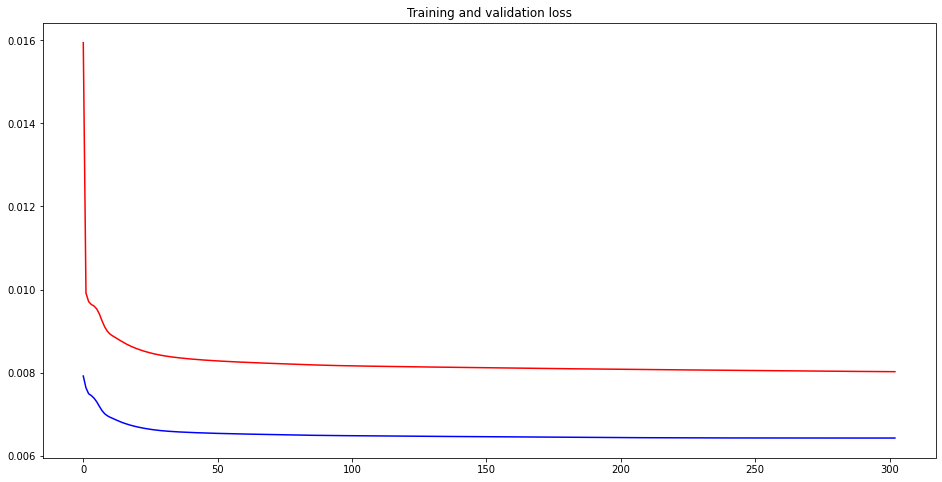

In [133]:
path = 'suhurh.h5'
modelckpt_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                     filepath=path, 
                                                     verbose=1, 
                                                     save_weights_only=False, 
                                                     save_best_only=True)
es_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, patience=10)
history = model.fit(train_X, train_y, epochs=500, batch_size=8, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False,
                    callbacks=[modelckpt_callback, es_callback])

loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(16, 8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.show()

In [134]:
model.load_weights(path)

In [135]:
pred = model.predict(test_X)
pred = scaler.inverse_transform(pred)
real = scaler.inverse_transform(YTest)
pred

array([[28.392149, 77.87124 ],
       [28.39337 , 74.63616 ],
       [28.383959, 73.60746 ],
       ...,
       [28.610823, 79.72526 ],
       [28.763346, 80.11984 ],
       [28.327421, 81.36441 ]], dtype=float32)

In [136]:
print('RMSE Suhu: {}'.format(numpy.sqrt(numpy.mean((pred[:, 0]-real[:, 0])**2))))
print('RMSE RH: {}'.format(numpy.sqrt(numpy.mean((pred[:, 1]-real[:, 1])**2))))

RMSE Suhu: 0.7174402945970367
RMSE RH: 3.674201627469388


#CO2

In [232]:
df = pd.read_csv('/content/dataset_co2.csv', delimiter=';')

In [233]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO2     125 non-null    float64
dtypes: float64(1)
memory usage: 1.1 KB


In [234]:
split = int(len(df)*.6)
dfTrain = df.iloc[:split, :]
dfTest = df.iloc[split:, :]

In [235]:
def deret_waktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [236]:
lag = 2
output = 1
reframedTrain = deret_waktu(dfTrain, lag, output)
reframedTest = deret_waktu(dfTest, lag, output)

In [237]:
reframedTest.head()

,var1(t-2),var1(t-1),var1(t)
77,78.077,83.190,88.150
78,83.190,88.150,96.579
79,88.150,96.579,97.246
80,96.579,97.246,84.463
81,97.246,84.463,86.071


In [238]:
n_features = len(df.columns)
YTrain = reframedTrain.iloc[:, -n_features:].values
YTest = reframedTest.iloc[:, -n_features:].values
n_obs = lag * n_features
train_X, train_y = reframedTrain.iloc[:, :n_obs].values, YTrain
test_X, test_y = reframedTest.iloc[:, :n_obs].values, YTest
train_X = train_X.reshape((train_X.shape[0], lag, n_features))
test_X = test_X.reshape((test_X.shape[0], lag, n_features))

In [239]:
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[-2:])))
model.add(Dense(n_features, activation="relu"))
model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
              loss='mse')  
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 256)               264192    
                                                                 
 dense_18 (Dense)            (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500

Epoch 1: val_loss improved from inf to 7800.86377, saving model to co2.h5
10/10 - 2s - loss: 5297.8301 - val_loss: 7800.8638 - 2s/epoch - 195ms/step
Epoch 2/500

Epoch 2: val_loss improved from 7800.86377 to 7194.67969, saving model to co2.h5
10/10 - 0s - loss: 4823.8052 - val_loss: 7194.6797 - 91ms/epoch - 9ms/step
Epoch 3/500

Epoch 3: val_loss improved from 7194.67969 to 6436.96826, saving model to co2.h5
10/10 - 0s - loss: 4280.7554 - val_loss: 6436.9683 - 89ms/epoch - 9ms/step
Epoch 4/500

Epoch 4: val_loss improved from 6436.96826 to 5560.52490, saving model to co2.h5
10/10 - 0s - loss: 3614.2385 - val_loss: 5560.5249 - 82ms/epoch - 8ms/step
Epoch 5/500

Epoch 5: val_loss improved from 5560.52490 to 5052.21338, saving model to co2.h5
10/10 - 0s - loss: 3113.3413 - val_loss: 5052.2134 - 92ms/epoch - 9ms/step
Epoch 6/500

Epoch 6: val_loss improved from 5052.21338 to 4615.85303, saving model to co2.h5
10/10 - 0s - loss: 2774.1953 - val_loss: 4615.8530 - 91ms/epoch - 9m

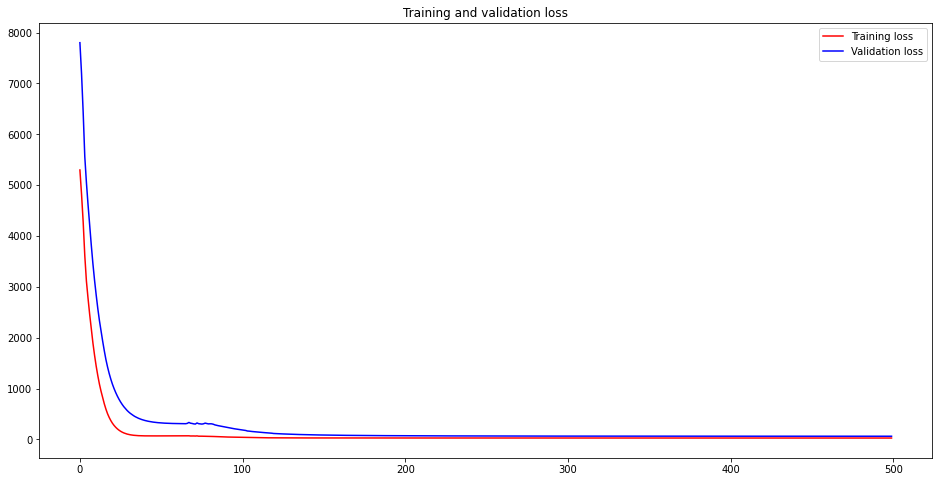

In [240]:
path = 'co2.h5'
modelckpt_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                     filepath=path, 
                                                     verbose=1, 
                                                     save_weights_only=False, 
                                                     save_best_only=True)
es_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, patience=10)
history = model.fit(train_X, train_y, epochs=500, batch_size=8, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False,
                    callbacks=[modelckpt_callback, es_callback])

loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(16, 8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.show()

In [241]:
model.load_weights(path)

In [242]:
pred = model.predict(test_X)
real = YTest
pred

array([[83.35397 ],
       [85.28352 ],
       [86.723404],
       [86.75409 ],
       [83.247116],
       [84.50447 ],
       [84.45995 ],
       [86.48218 ],
       [86.502625],
       [86.260124],
       [80.9     ],
       [82.90154 ],
       [86.08233 ],
       [86.61322 ],
       [85.591034],
       [85.94348 ],
       [86.50822 ],
       [86.604225],
       [84.31922 ],
       [85.461494],
       [86.92114 ],
       [86.60423 ],
       [86.451256],
       [86.22561 ],
       [86.77252 ],
       [86.54613 ],
       [84.41854 ],
       [85.901985],
       [86.466   ],
       [86.67798 ],
       [86.07715 ],
       [86.55163 ],
       [85.81262 ],
       [86.34596 ],
       [84.456345],
       [85.88512 ],
       [86.978195],
       [86.39854 ],
       [86.842384],
       [86.54272 ],
       [86.47224 ],
       [85.205635],
       [86.880585],
       [85.61694 ],
       [86.02511 ],
       [86.1521  ],
       [71.808624],
       [72.06874 ]], dtype=float32)

In [243]:
print('RMSE CO2: {}'.format(numpy.sqrt(numpy.mean((pred[:, 0]-real[:, 0])**2))))

RMSE CO2: 7.9170327132079725


#Debu

In [204]:
df = pd.read_csv('/content/dataset_debu.csv', delimiter=';')

In [205]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM10    416 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


In [206]:
split = int(len(df)*.6)
dfTrain = df.iloc[:split, :]
dfTest = df.iloc[split:, :]

In [207]:
def deret_waktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [208]:
lag = 2
output = 1
reframedTrain = deret_waktu(dfTrain, lag, output)
reframedTest = deret_waktu(dfTest, lag, output)

In [209]:
reframedTest.head()

,var1(t-2),var1(t-1),var1(t)
251,10.600119,13.364220,11.024105
252,13.364220,11.024105,11.453035
253,11.024105,11.453035,15.023557
254,11.453035,15.023557,10.410371
255,15.023557,10.410371,11.209158


In [210]:
n_features = len(df.columns)
YTrain = reframedTrain.iloc[:, -n_features:].values
YTest = reframedTest.iloc[:, -n_features:].values
n_obs = lag * n_features
train_X, train_y = reframedTrain.iloc[:, :n_obs].values, YTrain
test_X, test_y = reframedTest.iloc[:, :n_obs].values, YTest
train_X = train_X.reshape((train_X.shape[0], lag, n_features))
test_X = test_X.reshape((test_X.shape[0], lag, n_features))

In [211]:
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[-2:])))
model.add(Dense(n_features, activation="relu"))
model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
              loss='mse')  
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 256)               264192    
                                                                 
 dense_15 (Dense)            (None, 1)                 257       
                                                                 
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500

Epoch 1: val_loss improved from inf to 2.50895, saving model to debu.h5
31/31 - 0s - loss: 2.4225 - val_loss: 2.5090 - 250ms/epoch - 8ms/step
Epoch 2/500

Epoch 2: val_loss improved from 2.50895 to 2.36881, saving model to debu.h5
31/31 - 0s - loss: 2.5001 - val_loss: 2.3688 - 278ms/epoch - 9ms/step
Epoch 3/500

Epoch 3: val_loss did not improve from 2.36881
31/31 - 0s - loss: 2.4375 - val_loss: 2.5349 - 244ms/epoch - 8ms/step
Epoch 4/500

Epoch 4: val_loss improved from 2.36881 to 2.35065, saving model to debu.h5
31/31 - 0s - loss: 2.4850 - val_loss: 2.3507 - 342ms/epoch - 11ms/step
Epoch 5/500

Epoch 5: val_loss did not improve from 2.35065
31/31 - 0s - loss: 2.3986 - val_loss: 2.4810 - 239ms/epoch - 8ms/step
Epoch 6/500

Epoch 6: val_loss improved from 2.35065 to 2.25493, saving model to debu.h5
31/31 - 0s - loss: 2.4128 - val_loss: 2.2549 - 400ms/epoch - 13ms/step
Epoch 7/500

Epoch 7: val_loss did not improve from 2.25493
31/31 - 0s - loss: 2.3154 - val_loss: 2.3419 -

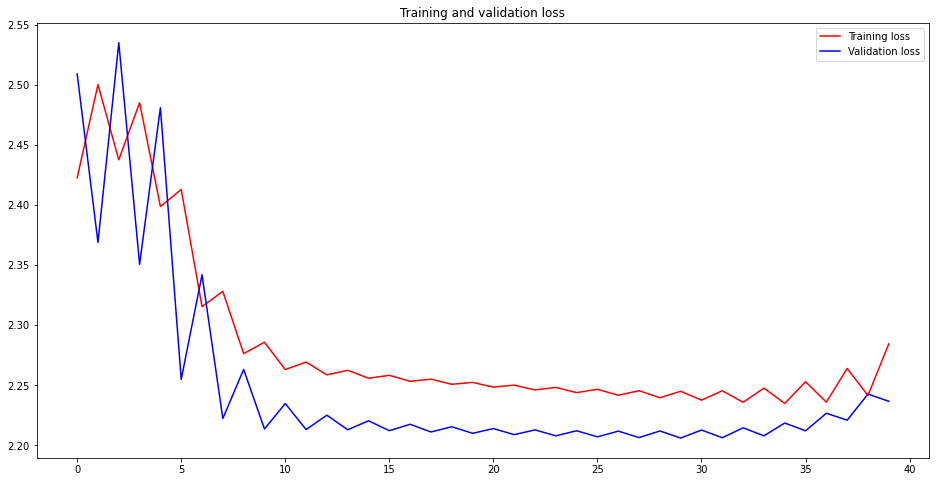

In [214]:
path = 'debu.h5'
modelckpt_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                     filepath=path, 
                                                     verbose=1, 
                                                     save_weights_only=False, 
                                                     save_best_only=True)
es_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, patience=10)
history = model.fit(train_X, train_y, epochs=500, batch_size=8, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False,
                    callbacks=[modelckpt_callback, es_callback])

loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(16, 8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.show()

In [215]:
model.load_weights(path)

In [216]:
pred = model.predict(test_X)
real = YTest
pred

array([[13.53678  ],
       [10.924589 ],
       [12.114279 ],
       [14.608066 ],
       [ 9.005384 ],
       [11.90324  ],
       [10.322703 ],
       [11.990847 ],
       [11.194369 ],
       [11.873602 ],
       [10.860042 ],
       [ 9.442156 ],
       [ 7.464162 ],
       [ 8.072557 ],
       [ 7.6561966],
       [ 7.167755 ],
       [ 6.714023 ],
       [ 7.9389496],
       [ 8.351317 ],
       [10.441409 ],
       [ 8.074084 ],
       [ 9.832464 ],
       [10.048638 ],
       [ 8.855127 ],
       [ 8.7864   ],
       [ 7.7769227],
       [ 8.365524 ],
       [ 8.771313 ],
       [ 8.665756 ],
       [ 8.478107 ],
       [ 9.571525 ],
       [11.130422 ],
       [ 9.776917 ],
       [10.822242 ],
       [10.142309 ],
       [10.555725 ],
       [ 8.08934  ],
       [ 8.088608 ],
       [ 8.063415 ],
       [ 9.344754 ],
       [ 9.063522 ],
       [ 8.591379 ],
       [ 9.934926 ],
       [10.460099 ],
       [ 9.342842 ],
       [ 8.496397 ],
       [ 9.942791 ],
       [ 9.76

In [217]:
print('RMSE Debu: {}'.format(numpy.sqrt(numpy.mean((pred[:, 0]-real[:, 0])**2))))

RMSE Debu: 1.4853085406429754


#Tekanan Udara

In [218]:
df = pd.read_csv('/content/dataset_tekanan_udara.csv', delimiter=';')

In [219]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3654 entries, 0 to 3653
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pressure  3654 non-null   float64
dtypes: float64(1)
memory usage: 28.7 KB


In [220]:
split = int(len(df)*.6)
dfTrain = df.iloc[:split, :]
dfTest = df.iloc[split:, :]

In [221]:
def deret_waktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [222]:
lag = 2
output = 1
reframedTrain = deret_waktu(dfTrain, lag, output)
reframedTest = deret_waktu(dfTest, lag, output)

In [223]:
reframedTest.head()

,var1(t-2),var1(t-1),var1(t)
2194,1.0076,1.0187,1.0285
2195,1.0187,1.0285,1.0258
2196,1.0285,1.0258,1.0179
2197,1.0258,1.0179,1.0209
2198,1.0179,1.0209,1.0263


In [224]:
n_features = len(df.columns)
YTrain = reframedTrain.iloc[:, -n_features:].values
YTest = reframedTest.iloc[:, -n_features:].values
n_obs = lag * n_features
train_X, train_y = reframedTrain.iloc[:, :n_obs].values, YTrain
test_X, test_y = reframedTest.iloc[:, :n_obs].values, YTest
train_X = train_X.reshape((train_X.shape[0], lag, n_features))
test_X = test_X.reshape((test_X.shape[0], lag, n_features))

In [227]:
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[-2:])))
model.add(Dense(n_features, activation="relu"))
model.compile(optimizer=tensorflow.keras.optimizers.Adam(),
              loss='mse')  
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (None, 512)               1052672   
                                                                 
 dense_17 (Dense)            (None, 1)                 513       
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500

Epoch 1: val_loss improved from inf to 0.00004, saving model to tekanan.h5
274/274 - 4s - loss: 0.0244 - val_loss: 3.6386e-05 - 4s/epoch - 14ms/step
Epoch 2/500

Epoch 2: val_loss did not improve from 0.00004
274/274 - 1s - loss: 3.9116e-05 - val_loss: 3.6888e-05 - 1s/epoch - 5ms/step
Epoch 3/500

Epoch 3: val_loss did not improve from 0.00004
274/274 - 2s - loss: 4.0407e-05 - val_loss: 3.6676e-05 - 2s/epoch - 5ms/step
Epoch 4/500

Epoch 4: val_loss improved from 0.00004 to 0.00004, saving model to tekanan.h5
274/274 - 2s - loss: 4.1538e-05 - val_loss: 3.6337e-05 - 2s/epoch - 6ms/step
Epoch 5/500

Epoch 5: val_loss did not improve from 0.00004
274/274 - 1s - loss: 4.2485e-05 - val_loss: 3.7283e-05 - 1s/epoch - 4ms/step
Epoch 6/500

Epoch 6: val_loss did not improve from 0.00004
274/274 - 1s - loss: 4.2802e-05 - val_loss: 3.7681e-05 - 1s/epoch - 4ms/step
Epoch 7/500

Epoch 7: val_loss improved from 0.00004 to 0.00004, saving model to tekanan.h5
274/274 - 1s - loss: 4.3277e-

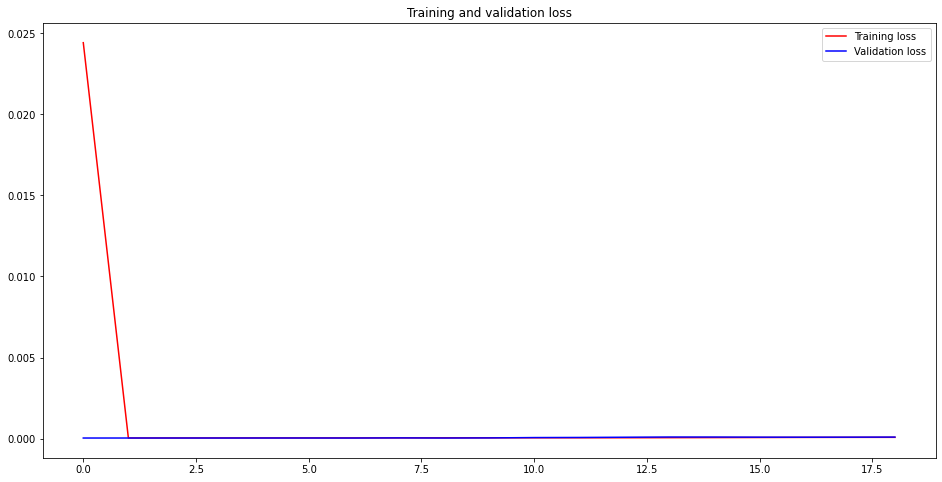

In [228]:
path = 'tekanan.h5'
modelckpt_callback = tensorflow.keras.callbacks.ModelCheckpoint(monitor="val_loss",
                                                     filepath=path, 
                                                     verbose=1, 
                                                     save_weights_only=False, 
                                                     save_best_only=True)
es_callback = tensorflow.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                            min_delta=0, patience=10)
history = model.fit(train_X, train_y, epochs=500, batch_size=8, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False,
                    callbacks=[modelckpt_callback, es_callback])

loss = history.history['loss']
epochs = range(len(loss))

plt.figure(figsize=(16, 8))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=1)
plt.show()

In [229]:
model.load_weights(path)

In [230]:
pred = model.predict(test_X)
real = YTest
pred

array([[1.0124111],
       [1.0205848],
       [1.0256045],
       ...,
       [1.0097868],
       [1.005673 ],
       [1.0024971]], dtype=float32)

In [231]:
print('RMSE Debu: {}'.format(numpy.sqrt(numpy.mean((pred[:, 0]-real[:, 0])**2))))

RMSE Debu: 0.006008579670685285


# K-Means

In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [332]:
a = pd.read_csv('/content/dataset_co2.csv', delimiter=';')
b = pd.read_csv('/content/dataset_debu.csv', delimiter=';')
c = pd.read_csv('/content/dataset_suhu_&_kelembapan.csv', delimiter=';')
d = pd.read_csv('/content/dataset_tekanan_udara.csv', delimiter=';')

df = pd.concat([a,b,c,d], axis=1)
df.dropna(inplace=True)
df

,CO2,PM10,Tavg,RH_avg,Pressure
0,72.076,13.413329,29.6,76.0,1.0286
1,64.442,9.098366,29.1,76.0,1.0318
2,64.084,6.363176,26.6,87.0,1.0314
3,60.842,4.621669,29.1,78.0,1.0262
4,61.798,5.254629,29.7,76.0,1.0246
...,...,...,...,...,...
120,91.658,8.068038,29.4,76.0,1.0198
121,92.416,9.587104,27.5,85.0,1.0171
122,72.840,7.563549,26.3,88.0,1.0161
123,71.410,5.585073,28.1,80.0,1.0175


In [254]:
scalerKmeans = MinMaxScaler()
x_scaled = scalerKmeans.fit_transform(df)
x_scaled

array([[0.29242317, 1.        , 0.7173913 , 0.3       , 0.77707006],
       [0.0988437 , 0.65071756, 0.60869565, 0.3       , 0.84501062],
       [0.0897657 , 0.42931276, 0.06521739, 0.85      , 0.83651805],
       [0.00755655, 0.28834333, 0.60869565, 0.4       , 0.72611465],
       [0.03179836, 0.33957945, 0.73913043, 0.3       , 0.69214437],
       [0.1519931 , 0.43357685, 0.73913043, 0.25      , 0.68789809],
       [0.30636981, 0.3298294 , 0.60869565, 0.3       , 0.73673036],
       [0.37115833, 0.28587297, 0.02173913, 0.95      , 0.69639066],
       [0.19913277, 0.20236701, 0.82608696, 0.1       , 0.68577495],
       [0.18064712, 0.22773951, 0.58695652, 0.3       , 0.88535032],
       [0.1642408 , 0.17652936, 0.34782609, 0.6       , 0.96178344],
       [0.26813064, 0.20112133, 0.        , 0.9       , 0.84713376],
       [0.25372756, 0.16176697, 0.47826087, 0.4       , 0.64968153],
       [0.06047774, 0.16326874, 0.76086957, 0.2       , 0.6581741 ],
       [0.10079623, 0.23004456, 0.

In [255]:
joblib.dump(scalerKmeans, 'scalerKmeans.gz')

['scalerKmeans.gz']

In [250]:
kmeans = KMeans(n_clusters = 2, random_state=44)
kmeans.fit(x_scaled)

KMeans(n_clusters=2, random_state=44)

In [251]:
joblib.dump(kmeans, 'kmeans.gz')

['kmeans.gz']

In [145]:
print(kmeans.cluster_centers_)

[[0.29149082 0.5046268  0.42028986 0.52463768 0.74211514]
 [0.77578953 0.29150608 0.5298913  0.54910714 0.45530027]]


In [146]:
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1], dtype=int32)

In [148]:
df['kluster'] = kmeans.labels_
df

,CO2,PM10,Tavg,RH_avg,Pressure,kluster
0,72.076,13.413329,29.6,76.0,1.0286,0
1,64.442,9.098366,29.1,76.0,1.0318,0
2,64.084,6.363176,26.6,87.0,1.0314,0
3,60.842,4.621669,29.1,78.0,1.0262,0
4,61.798,5.254629,29.7,76.0,1.0246,0
...,...,...,...,...,...,...
120,91.658,8.068038,29.4,76.0,1.0198,1
121,92.416,9.587104,27.5,85.0,1.0171,1
122,72.840,7.563549,26.3,88.0,1.0161,0
123,71.410,5.585073,28.1,80.0,1.0175,0


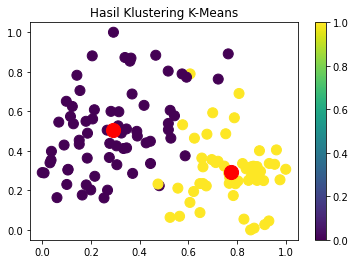

In [158]:
# Scatter plot pada variabel CO2 dan PM10
output = plt.scatter(x_scaled[:,0], x_scaled[:,1], s = 100, c = df.kluster, marker = 'o', alpha = 1, )
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=200, alpha=1 , marker='o');
plt.title('Hasil Klustering K-Means')
plt.colorbar (output)
plt.show()

In [159]:
df.to_csv('cluster.csv', index=False)

Dilakukan analisis berdasarkan threshold kebencanaan, dapat diketahui bahwa cluster 0 merupakan kondisi normal, sementara cluster 1 merupakan kondisi bahaya

# Pengujian

##Forecast LSTM

In [404]:
# memasukkan data test
df = pd.read_csv('testingbencana.csv')
df

,CO2,PM10,Tavg,RH_avg,Pressure
0,82.785,1.913064,29.0,78,1.0104
1,91.484,3.206393,28.6,81,1.0083
2,95.662,4.636185,30.3,75,1.0133
3,90.030,5.047564,27.8,86,1.0088
4,91.239,4.541016,29.1,74,1.0080
5,94.766,5.039819,29.6,75,1.0028
6,95.724,6.010529,30.0,73,0.9920
7,72.559,6.313823,27.3,84,1.0333
8,63.221,7.797117,28.2,80,1.0297
9,65.418,8.776600,28.8,81,1.0170


In [405]:
modelsuhurh = tensorflow.keras.models.load_model('suhurh.h5')
modelco2 = tensorflow.keras.models.load_model('co2.h5')
modeltekanan = tensorflow.keras.models.load_model('tekanan.h5')
modeldebu = tensorflow.keras.models.load_model('debu.h5')

In [406]:
scaler = joblib.load('scalersuhurh.gz')
suhurh = scaler.transform(df.iloc[:, 2:4])
suhurh

array([[0.52439024, 0.64705882],
       [0.47560976, 0.70588235],
       [0.68292683, 0.58823529],
       [0.37804878, 0.80392157],
       [0.53658537, 0.56862745],
       [0.59756098, 0.58823529],
       [0.64634146, 0.54901961],
       [0.31707317, 0.76470588],
       [0.42682927, 0.68627451],
       [0.5       , 0.70588235],
       [0.35365854, 0.76470588],
       [0.32926829, 0.78431373],
       [0.42682927, 0.74509804],
       [0.2804878 , 0.88235294],
       [0.2804878 , 0.82352941],
       [0.20731707, 0.80392157],
       [0.48780488, 0.64705882]])

In [407]:
def deret_waktu(data, n_in=1, n_out=1, dropnan=True,):
    n_vars = (1 if type(data) is list else data.shape[1])
    df = DataFrame(data)
    (cols, names) = (list(), list())
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += ['var%d(t-%d)' % (j + 1, i) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += ['var%d(t)' % (j + 1) for j in range(n_vars)]
        else:
            names += ['var%d(t+%d)' % (j + 1, i) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [408]:
lag = 2
reframedSuhuRh = deret_waktu(suhurh, lag, 0).values
reframedCO2 = deret_waktu(df.CO2.values.tolist(), lag, 0).values
reframedTekanan = deret_waktu(df.Pressure.values.tolist(), lag, 0).values
reframedDebu = deret_waktu(df.PM10.values.tolist(), lag, 0).values

In [409]:
reframedSuhuRh = reframedSuhuRh.reshape(reframedSuhuRh.shape[0], lag, 2)
reframedCO2 = reframedCO2.reshape(reframedCO2.shape[0], lag, 1)
reframedTekanan = reframedTekanan.reshape(reframedCO2.shape[0], lag, 1)
reframedDebu = reframedDebu.reshape(reframedCO2.shape[0], lag, 1)

In [410]:
suhurhPred = modelsuhurh.predict(reframedSuhuRh)
suhurhPred = scaler.inverse_transform(suhurhPred)

co2Pred = modelco2.predict(reframedCO2)

tekananPred = modeltekanan.predict(reframedTekanan)

debuPred = modeldebu.predict(reframedDebu)

In [411]:
dfPred = pd.concat([pd.DataFrame(co2Pred), pd.DataFrame(debuPred), pd.DataFrame(suhurhPred), pd.DataFrame(tekananPred)], axis=1)
dfPred.set_axis(df.columns, axis=1, inplace=True)
dfPred

,CO2,PM10,Tavg,RH_avg,Pressure
0,86.082321,3.502042,28.642754,80.344704,1.011982
1,86.613205,5.045492,29.552738,78.226715,1.011762
2,85.591034,5.719075,28.440432,82.512672,1.013718
3,85.943481,5.189008,28.892061,77.813156,1.011019
4,86.508224,5.705101,29.209677,76.211502,1.009561
5,86.604218,6.645941,29.554359,75.226135,1.004532
6,71.390083,6.986192,28.255688,80.681709,1.006414
7,65.007240,8.449786,28.363041,80.018028,1.029075
8,67.943970,9.516565,28.686659,80.551094,1.024579
9,67.793648,8.058274,28.201126,81.807076,1.017030


##Mencari Cluster dengan K-Means

In [412]:
scalerKmeans = joblib.load('scalerKmeans.gz')
kmeans = joblib.load('kmeans.gz')

In [413]:
dfPredScaled = scalerKmeans.transform(dfPred)
dfPredScaled

array([[0.6475891 , 0.19771318, 0.5092942 , 0.5172353 , 0.4242401 ],
       [0.6610509 , 0.32265046, 0.7071168 , 0.4113357 , 0.41957283],
       [0.63513124, 0.37717482, 0.46531123, 0.6256337 , 0.46110916],
       [0.64406836, 0.33426765, 0.5634915 , 0.3906579 , 0.40380287],
       [0.658389  , 0.37604365, 0.6325385 , 0.310575  , 0.37283897],
       [0.660823  , 0.45220166, 0.70746964, 0.26130676, 0.2660675 ],
       [0.27503002, 0.4797439 , 0.42514962, 0.5340853 , 0.3060341 ],
       [0.11317681, 0.5982171 , 0.44848698, 0.5009012 , 0.7871456 ],
       [0.18764506, 0.6845695 , 0.51883906, 0.5275545 , 0.6917    ],
       [0.18383323, 0.5665255 , 0.4132883 , 0.59035397, 0.53141403],
       [0.32759404, 0.65932184, 0.37286252, 0.60833263, 0.54312325],
       [0.33009374, 0.543109  , 0.45927542, 0.58061314, 0.67152023],
       [0.15365826, 0.63284564, 0.35359782, 0.6966629 , 0.7733574 ],
       [0.20509015, 0.47126216, 0.34996337, 0.6594448 , 0.83086777],
       [0.10196351, 0.38330463, 0.

In [414]:
dfPredScaled = dfPredScaled.astype(float)
clusterPred = kmeans.predict(dfPredScaled)
clusterPred

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [416]:
dfPred['Kategori'] = clusterPred
dfPred.loc[dfPred['Kategori'] == 1, 'Kategori'] = 'Bahaya'
dfPred.loc[dfPred['Kategori'] == 0, 'Kategori'] = 'Normal'
dfPred

,CO2,PM10,Tavg,RH_avg,Pressure,Kategori
0,86.082321,3.502042,28.642754,80.344704,1.011982,Bahaya
1,86.613205,5.045492,29.552738,78.226715,1.011762,Bahaya
2,85.591034,5.719075,28.440432,82.512672,1.013718,Bahaya
3,85.943481,5.189008,28.892061,77.813156,1.011019,Bahaya
4,86.508224,5.705101,29.209677,76.211502,1.009561,Bahaya
5,86.604218,6.645941,29.554359,75.226135,1.004532,Bahaya
6,71.390083,6.986192,28.255688,80.681709,1.006414,Normal
7,65.007240,8.449786,28.363041,80.018028,1.029075,Normal
8,67.943970,9.516565,28.686659,80.551094,1.024579,Normal
9,67.793648,8.058274,28.201126,81.807076,1.017030,Normal


In [418]:
shutil.make_archive('file', 'zip', '/content/')

'/content/file.zip'